In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install --upgrade gymnasium
!pip install --upgrade stable-baselines3

In [3]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from tabulate import tabulate
import gymnasium as gym
from gymnasium import spaces

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [4]:
print(gym.__version__)

1.2.0


In [5]:
import stable_baselines3
print(stable_baselines3.__version__)

2.7.0


In [6]:
#Loading data
routes=pd.read_csv('/content/routes.txt',low_memory=False)
stop_times=pd.read_csv('/content/stop_times.txt',low_memory=False)
trips=pd.read_csv('/content/trips.txt',low_memory=False)

In [7]:
#Viewing the trips dataframe
trips.head(10)

,route_id,service_id,trip_id,realtime_trip_id,trip_headsign,trip_short_name,trip_long_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
0,17562,139,260620395,IFF:IC:2819,Utrecht Centraal,2819,Intercity,0,NaN,1371235.0,0,1.0
1,17562,2271,260620646,IFF:IC:2880,Rotterdam Centraal,2880,Intercity,1,294808.0,1371234.0,0,1.0
2,17562,2405,260620674,IFF:IC:2877,Enschede,2877,Intercity,0,287257.0,1371235.0,0,1.0
3,17562,2107,260620718,IFF:IC:2881,Enschede,2881,Intercity,0,293169.0,1371235.0,0,1.0
4,17562,681,260620732,IFF:IC:2826,Rotterdam Centraal,2826,Intercity,1,NaN,1371234.0,0,1.0
5,17562,2484,260620734,IFF:IC:2835,Enschede,2835,Intercity,0,327461.0,1371235.0,0,1.0
6,17562,682,260620735,IFF:IC:2835,Utrecht Centraal,2835,Intercity,0,NaN,1371235.0,0,1.0
7,17562,815,260620754,IFF:IC:2885,Enschede,2885,Intercity,0,293383.0,1371235.0,0,1.0
8,17562,3599,260620762,IFF:IC:2825,Enschede,2825,Intercity,0,286851.0,1371235.0,0,1.0
9,17562,612,260620765,IFF:IC:2825,Utrecht Centraal,2825,Intercity,0,NaN,1371235.0,0,1.0


In [8]:
#Dropping NA values
trips.dropna(inplace=True)

In [9]:
#extracting only rail routes since the dataset contains all modes (buses,trams)
rail_routes=routes[routes['route_type']==2]

In [10]:
#Viewing unique route_id
rail_routes['route_id'].unique()

array([122296,  86478,  86480,  86482,  86485,  86486,  86487,  86488,
        86489,  86490,  86491,  86492,  86497,  86502, 119424, 119684,
       120375, 124365, 124366, 124367, 124368, 124370, 129445, 129447,
       129448, 129449, 129450, 129814, 129815, 129817, 130157, 131746,
        85013,  85014,  85015,  85016,  85017,  85018,  85019,  85020,
       118107,  98655, 124379, 124380, 124382, 130423,  17562,  17627,
        17641,  17658,  17661,  17705,  17748,  17792,  17803,  17828,
        37294,  41202,  41208,  41216,  41226,  41236,  41239,  43187,
        44942,  44947,  45194,  52986,  52991,  66765,  67394,  67402,
        73941,  79951,  83134,  84150,  84247,  90300,  90309,  90312,
       109575, 114870, 114871, 114873, 114874, 114875, 114876, 114877,
       114878, 114879, 114880, 114897, 114898, 114899, 114900, 114901,
       114902, 114903, 114904, 114906, 114907, 114908, 114909, 114910,
       114911, 114912, 114913, 114914, 114915, 120390, 124450, 124451,
      

In [11]:
#choosing route
trips['route_id'] = trips['route_id'].astype(str)
route_counts = trips['route_id'].value_counts().reset_index()
route_counts.columns = ['route_id', 'trip_count']
route_counts.head(100)

,route_id,trip_count
0,17562,243
1,17705,243
2,83134,121
3,52986,82
4,114876,72
5,114874,70
6,114903,59
7,17828,58
8,130436,51
9,17748,23


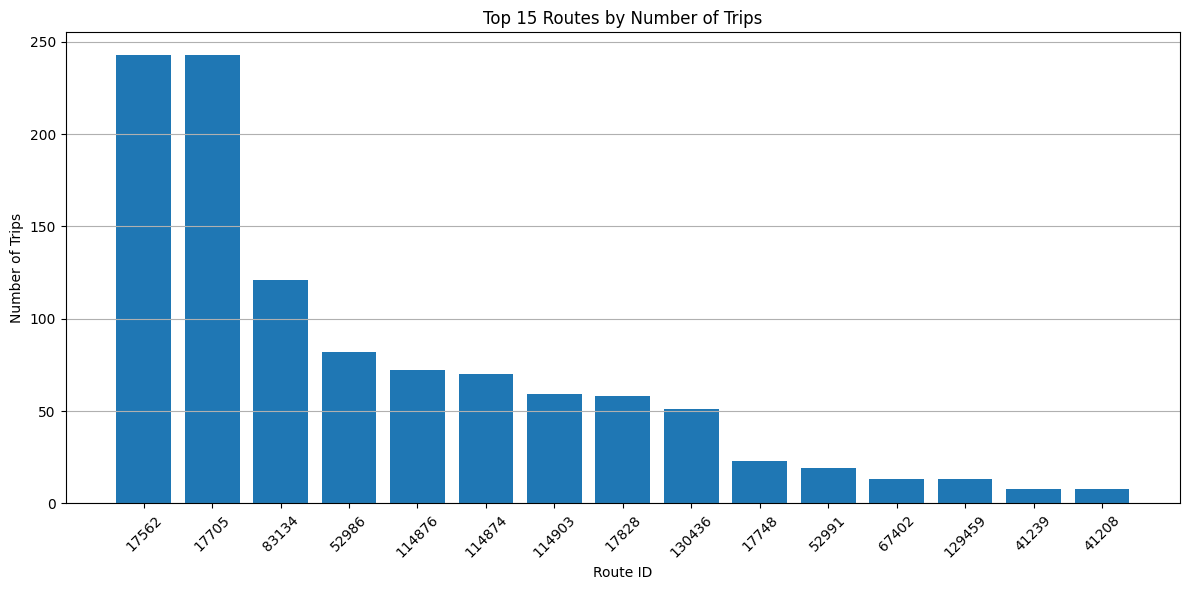

In [12]:
#Plotting top 15 for route selection
plt.figure(figsize=(12, 6))
plt.bar(route_counts['route_id'][:15], route_counts['trip_count'][:15])
plt.xlabel('Route ID')
plt.ylabel('Number of Trips')
plt.title('Top 15 Routes by Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [13]:
selected_id= '17562'
print(trips[trips['route_id'] == selected_id].shape)

(243, 12)


In [14]:
selected_trip=trips[trips['route_id']=='17562']
selected_trip.head(15)

,route_id,service_id,trip_id,realtime_trip_id,trip_headsign,trip_short_name,trip_long_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed
1,17562,2271,260620646,IFF:IC:2880,Rotterdam Centraal,2880,Intercity,1,294808.0,1371234.0,0,1.0
2,17562,2405,260620674,IFF:IC:2877,Enschede,2877,Intercity,0,287257.0,1371235.0,0,1.0
3,17562,2107,260620718,IFF:IC:2881,Enschede,2881,Intercity,0,293169.0,1371235.0,0,1.0
5,17562,2484,260620734,IFF:IC:2835,Enschede,2835,Intercity,0,327461.0,1371235.0,0,1.0
7,17562,815,260620754,IFF:IC:2885,Enschede,2885,Intercity,0,293383.0,1371235.0,0,1.0
8,17562,3599,260620762,IFF:IC:2825,Enschede,2825,Intercity,0,286851.0,1371235.0,0,1.0
10,17562,1935,260620777,IFF:IC:2882,Rotterdam Centraal,2882,Intercity,1,289871.0,1371234.0,0,1.0
12,17562,2047,260620785,IFF:IC:2876,Rotterdam Centraal,2876,Intercity,1,282197.0,1371234.0,0,1.0
14,17562,2178,260620807,IFF:IC:2879,Enschede,2879,Intercity,0,294196.0,1371235.0,0,1.0
15,17562,1721,260620815,IFF:IC:2874,Rotterdam Centraal,2874,Intercity,1,296482.0,1371234.0,0,1.0


In [15]:
#Number of stops for the route ID 17562
trip_ids = selected_trip['trip_id']
stop_selected = stop_times.query("trip_id in @trip_ids")
stop_selected['stop_id'].nunique()

16

In [16]:
# Route details
route_details = routes[routes['route_id'].astype(str) == '17562']
route_details

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_color,route_text_color,route_url
1295,17562,IFF:NS,Intercity,Rotterdam Centraal <-> Utrecht Centraal IC2800,NaN,2,NaN,NaN,NaN


In [17]:
#Merging for getting the full train schedule
schedule = pd.merge(stop_times,selected_trip[['trip_id', 'route_id']], on='trip_id', how='inner')
schedule = schedule[['trip_id', 'stop_sequence', 'arrival_time', 'departure_time']]
schedule.dropna()
schedule = schedule.sort_values(by=['trip_id', 'stop_sequence'])
schedule

,trip_id,stop_sequence,arrival_time,departure_time
0,260620646,1,23:03:00,23:03:00
1,260620646,7,23:21:00,23:22:00
2,260620646,10,23:31:00,23:31:00
3,260620646,12,23:40:00,23:40:00
4,260620674,1,20:50:00,20:50:00
...,...,...,...,...
967,297118648,12,25:10:00,25:10:00
968,297118936,1,23:50:00,23:50:00
969,297118936,3,23:58:00,23:58:00
970,297118936,6,24:08:00,24:09:00


In [18]:
#converting to minutes
def time_to_minutes(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

In [19]:
#Applying the time conversion to the columns arrival_time & departure_time
schedule['arrival_time_mins'] = schedule['arrival_time'].apply(time_to_minutes)
schedule['departure_time_mins'] = schedule['departure_time'].apply(time_to_minutes)
schedule.head(10)

,trip_id,stop_sequence,arrival_time,departure_time,arrival_time_mins,departure_time_mins
0,260620646,1,23:03:00,23:03:00,1383.0,1383.0
1,260620646,7,23:21:00,23:22:00,1401.0,1402.0
2,260620646,10,23:31:00,23:31:00,1411.0,1411.0
3,260620646,12,23:40:00,23:40:00,1420.0,1420.0
4,260620674,1,20:50:00,20:50:00,1250.0,1250.0
5,260620674,3,20:58:00,20:58:00,1258.0,1258.0
6,260620674,6,21:08:00,21:09:00,1268.0,1269.0
7,260620674,12,21:27:00,21:27:00,1287.0,1287.0
8,260620718,1,21:50:00,21:50:00,1310.0,1310.0
9,260620718,3,21:58:00,21:58:00,1318.0,1318.0


In [20]:
#checking whether NA is there or not
schedule.isna().sum()

,0
trip_id,0
stop_sequence,0
arrival_time,0
departure_time,0
arrival_time_mins,0
departure_time_mins,0


In [21]:
print("Schedule shape:", schedule.shape)
print(schedule.head())

Schedule shape: (972, 6)
     trip_id  stop_sequence arrival_time departure_time  arrival_time_mins  \
0  260620646              1     23:03:00       23:03:00             1383.0   
1  260620646              7     23:21:00       23:22:00             1401.0   
2  260620646             10     23:31:00       23:31:00             1411.0   
3  260620646             12     23:40:00       23:40:00             1420.0   
4  260620674              1     20:50:00       20:50:00             1250.0   

   departure_time_mins  
0               1383.0  
1               1402.0  
2               1411.0  
3               1420.0  
4               1250.0  


In [22]:
import random
def random_delay(reason):
    if reason == "weather":
        return random.randint(5, 15)
    elif reason == "Track Maintenance":
        return random.randint(10, 20)
    else:
        return random.randint(1, 5)

In [23]:
class RailwayRescheduleEnv(gym.Env):

    def __init__(self, schedule,fault_probability=0.2):
        super(RailwayRescheduleEnv, self).__init__()
        self.schedule = schedule.copy()
        self.current_stop = 0
        self.total_stops = len(self.schedule)
        self.time = 0
        self.max_time = self.total_stops * 10
        self.add_random_delays = False
        self.fault_probability = fault_probability

        self.train_ids = list(self.schedule['trip_id'].unique())
        self.num_trains = len(self.train_ids)
        self.prev_total_delay = 0

        self.delay = {}
        self.train_states = {}

        for train_id in self.train_ids:
            filtered = self.schedule[self.schedule['trip_id'] == train_id]
            if filtered.empty:
                raise ValueError(f"No rows found for train_id {train_id} during initialization.")
            row = filtered.head(1).iloc[0]
            self.train_states[train_id] = {
                'status': 'not arrived',
                'scheduled_arrival': row['arrival_time_mins'],
                'scheduled_departure': row['departure_time_mins'],
                'actual_arrival': row['arrival_time_mins'],
                'actual_departure': row['departure_time_mins']
            }
            self.delay[train_id] = 0  # Initialize delay for each train

        self.action_space = spaces.Box(low=0, high=5, shape=(self.num_trains,), dtype=np.int32)
        observation_min = np.tile([0, 0, 0, 0], self.num_trains)
        observation_max = np.tile([2, 2000, 2000, 500], self.num_trains)
        self.observation_space = spaces.Box(low=observation_min, high=observation_max, dtype=np.int32)

    def simulate_random_delays(self):
     for train_id in self.schedule['trip_id'].unique():
        if random.random() < self.fault_probability:
            reason = random.choice(['weather', 'Track Maintenance'])
            delay = random_delay(reason)
            self.delay[train_id] += delay
            self.train_states[train_id]['actual_arrival'] += delay
            self.train_states[train_id]['actual_departure'] += delay


    def step(self, actions):
     self.time += 1
     actions = np.clip(np.array(actions).flatten(), 0, 5)

     for i, tid in enumerate(self.train_ids):
        delay_adjust = int(actions[i])  # Treat action as additional delay in minutes
        self.delay[tid] += delay_adjust

        state = self.train_states[tid]
        state['actual_arrival'] = state['scheduled_arrival'] + self.delay[tid]
        state['actual_departure'] = state['scheduled_departure'] + self.delay[tid]

     for tid in self.train_states:
        state = self.train_states[tid]
        if state['status'] == 'not arrived' and self.time >= state['actual_arrival']:
            state['status'] = 'arrived'
        elif state['status'] == 'arrived' and self.time >= state['actual_departure']:
            state['status'] = 'departed'

    # New reward strategy
     total_positive_delay = sum([max(d, 0) for d in self.delay.values()])
     delay_reduction = self.prev_total_delay - total_positive_delay
     on_time_bonus = sum([1 for s in self.train_states.values()
                         if s['status'] == 'departed' and (s['actual_departure'] - s['scheduled_departure']) <= 0])

     reward = delay_reduction + (5 * on_time_bonus)
     self.prev_total_delay = total_positive_delay
     reward = np.clip(reward, -1000, 1000)

     terminated = all(state['status'] == 'departed' for state in self.train_states.values())
     truncated = self.time >= self.max_time

    # Observation
     status_map = {'not arrived': 0, 'arrived': 1, 'departed': 2}
     obs_list = []
     for tid in self.train_ids:
        state = self.train_states[tid]
        obs_list.extend([
            status_map.get(state['status'], 2),
            state['actual_arrival'] / 2000,
            state['actual_departure'] / 2000,
            self.delay[tid] / 500
        ])

     return np.array(obs_list, dtype=np.float32), reward, terminated, truncated, {}

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.time = 0
        self.delay = {}
        self.train_states = {}
        self.prev_total_delay = 0

        for train_id in self.schedule['trip_id'].unique():
            filtered = self.schedule[self.schedule['trip_id'] == train_id]
            if filtered.empty:
                raise ValueError(f"No rows found for train_id {train_id} during reset.")
            row = filtered.head(1).iloc[0]

            self.delay[train_id] = 0
            self.train_states[train_id] = {
                'status': 'not arrived',
                'scheduled_arrival': row['arrival_time_mins'],
                'scheduled_departure': row['departure_time_mins'],
                'actual_arrival': row['arrival_time_mins'],
                'actual_departure': row['departure_time_mins']
            }

        if self.add_random_delays:
            self.simulate_random_delays()
        self.prev_total_delay = sum([max(0, self.delay[tid]) for tid in self.train_ids])
        status_map = {'not arrived': 0, 'arrived': 1}
        obs_list = []
        for tid in self.train_ids:
            state = self.train_states[tid]
            obs_list.extend([
                status_map.get(state['status'], 2),
                state['actual_arrival'] / 2000,
                state['actual_departure'] / 2000,
                self.delay[tid] / 500
            ])

        observations = np.array(obs_list, dtype=np.float32)
        info = {}
        return observations, info

    def render(self):
        print("\nCurrent Simulation Time:", self.time)
        for tid in self.train_states:
            state = self.train_states[tid]
            print("Train", tid)
            print("  Status:", state['status'])
            print("  Scheduled Arrival:", state['scheduled_arrival'])
            print("  Actual Arrival   :", state['actual_arrival'])
            print("  Scheduled Departure:", state['scheduled_departure'])
            print("  Actual Departure   :", state['actual_departure'])
            print("  Current Delay (in mins):", self.delay[tid])
            print()

In [24]:
#Training environment
env=RailwayRescheduleEnv(schedule,fault_probability=0.2)
obs,info=env.reset()
print(obs)

[0.     0.6915 0.6915 0.     0.     0.625  0.625  0.     0.     0.655
 0.655  0.     0.     0.31   0.31   0.     0.     0.685  0.685  0.
 0.     0.235  0.235  0.     0.     0.7065 0.7065 0.     0.     0.6615
 0.6615 0.     0.     0.64   0.64   0.     0.     0.6465 0.6465 0.
 0.     0.6465 0.6465 0.     0.     0.6465 0.6465 0.     0.     0.25
 0.25   0.     0.     0.7215 0.7215 0.     0.     0.7215 0.7215 0.
 0.     0.7365 0.7365 0.     0.     0.7    0.7    0.     0.     0.7
 0.7    0.     0.     0.6915 0.6915 0.     0.     0.19   0.19   0.
 0.     0.2565 0.2565 0.     0.     0.7365 0.7365 0.     0.     0.205
 0.205  0.     0.     0.715  0.715  0.     0.     0.625  0.625  0.
 0.     0.2715 0.2715 0.     0.     0.2865 0.2865 0.     0.     0.67
 0.67   0.     0.     0.6915 0.6915 0.     0.     0.67   0.67   0.
 0.     0.655  0.655  0.     0.     0.655  0.655  0.     0.     0.6765
 0.6765 0.     0.     0.7065 0.7065 0.     0.     0.7065 0.7065 0.
 0.     0.64   0.64   0.     0.     0.64   

In [25]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

fault_levels = [0.0, 0.02, 0.05, 0.1, 0.2]
model_ppo = None

for level in fault_levels:
    print(f"\nTraining PPO with fault probability: {level}")

    # environment with the fault probability
    def make_env():
        return RailwayRescheduleEnv(schedule, fault_probability=level)

    env = DummyVecEnv([make_env])
    env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_reward=10.0)


    if model_ppo is None:
        model_ppo = PPO("MlpPolicy", env, verbose=1)
    else:
        model_ppo.set_env(env)

    # model Training
    model_ppo.learn(total_timesteps=10000)


Training PPO with fault probability: 0.0
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 535  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 369        |
|    iterations           | 2          |
|    time_elapsed         | 11         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.44332987 |
|    clip_fraction        | 0.635      |
|    clip_range           | 0.2        |
|    entropy_loss         | -345       |
|    explained_variance   | 0.00298    |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0972    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0907    |
|    std                  | 0.999      |
|    value_loss           | 0.326 

In [26]:
# To make trained PPO model to make predictions
obs = env.reset()

for _ in range(1000):
    action, _ = model_ppo.predict(obs)
    obs, reward, done, info = env.step(action)
    if done.any():
        obs = env.reset()

In [27]:
fault_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

for fault_prob in fault_levels:
    def make_env():
        return RailwayRescheduleEnv(schedule, fault_probability=fault_prob)

    env = DummyVecEnv([make_env])
    env = VecNormalize(env, norm_reward=True, clip_reward=10.0)

    model= A2C("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 304      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -346     |
|    explained_variance | -72.4    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -84.2    |
|    std                | 1        |
|    value_loss         | 0.0744   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 273      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -345     |
|    explained_variance | -51.8    |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss     

In [28]:
#Evaluate A2C model
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
        obs = env.reset()

In [29]:
def _episode_avg_delay(env, max_steps=200, action_fn=None):
    obs, _ = env.reset()
    for _ in range(max_steps):
        a = action_fn(obs) if action_fn is not None else env.action_space.sample()
        obs, reward, term, trunc, info = env.step(a)
        if term or trunc:
            break
    # final per-train delays; ensure non-negative "lateness"
    vals = np.array(list(env.delay.values()), dtype=float)
    return float(np.mean(np.clip(vals, 0, None))) if vals.size else np.nan

In [30]:
#Evaluation
def evaluate_delay_model(model, fault_prob=0.20, num_episodes=100, max_steps=200):
    vals = []
    for _ in range(num_episodes):
        env = RailwayRescheduleEnv(schedule, fault_probability=fault_prob)
        env.add_random_delays = True
        vals.append(_episode_avg_delay(
            env, max_steps,
            action_fn=lambda obs: model.predict(obs, deterministic=True)[0]
        ))
    return float(np.nanmean(vals)), float(np.nanstd(vals))

In [31]:
def evaluate_delay_random(fault_prob=0.20, num_episodes=100, max_steps=200):
    vals = []
    for _ in range(num_episodes):
        env = RailwayRescheduleEnv(schedule, fault_probability=fault_prob)
        env.add_random_delays = True
        vals.append(_episode_avg_delay(env, max_steps, action_fn=None))
    return float(np.nanmean(vals)), float(np.nanstd(vals))

In [32]:
FP = 0.1

# run evals
mean_ppo,  std_ppo  = evaluate_delay_model(model_ppo, fault_prob=FP)
mean_a2c,  std_a2c  = evaluate_delay_model(model,     fault_prob=FP)


df_models = pd.DataFrame({
    "Model": ["PPO", "A2C"],
    "Mean Avg Delay": [mean_ppo, mean_a2c],
    "Std": [std_ppo, std_a2c]
})

In [33]:
df_models

,Model,Mean Avg Delay,Std
0,PPO,1.263663,0.211235
1,A2C,1.242469,0.246404


#Avg delay Vs Model for Fault Probability 0.1

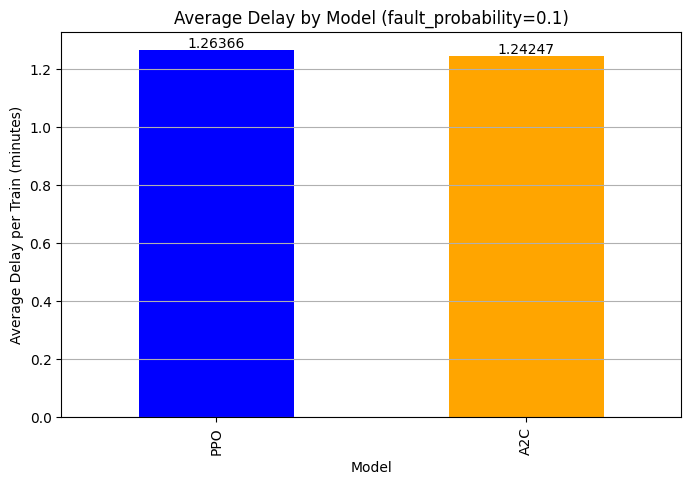

In [34]:
colors=['blue','orange']
ax = df_models.plot(kind="bar", x="Model", y="Mean Avg Delay", legend=False, figsize=(8,5),color=colors)
ax.set_ylabel("Average Delay per Train (minutes)")
ax.set_title(f"Average Delay by Model (fault_probability={FP})")
ax.grid(axis="y")
ax.bar_label(ax.containers[0])
plt.show()

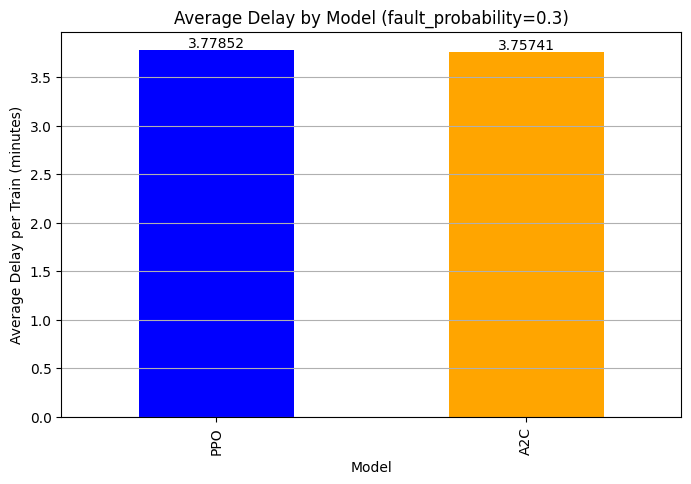

In [35]:
FP = 0.3

mean_ppo,  std_ppo  = evaluate_delay_model(model_ppo, fault_prob=FP)
mean_a2c,  std_a2c  = evaluate_delay_model(model,     fault_prob=FP)


df_models = pd.DataFrame({
    "Model": ["PPO", "A2C"],
    "Mean Avg Delay": [mean_ppo, mean_a2c],
    "Std": [std_ppo, std_a2c]
})
colors=['blue','orange']
ax = df_models.plot(kind="bar", x="Model", y="Mean Avg Delay", legend=False, figsize=(8,5),color=colors)
ax.set_ylabel("Average Delay per Train (minutes)")
ax.set_title(f"Average Delay by Model (fault_probability={FP})")
ax.grid(axis="y")
ax.bar_label(ax.containers[0])
plt.show()

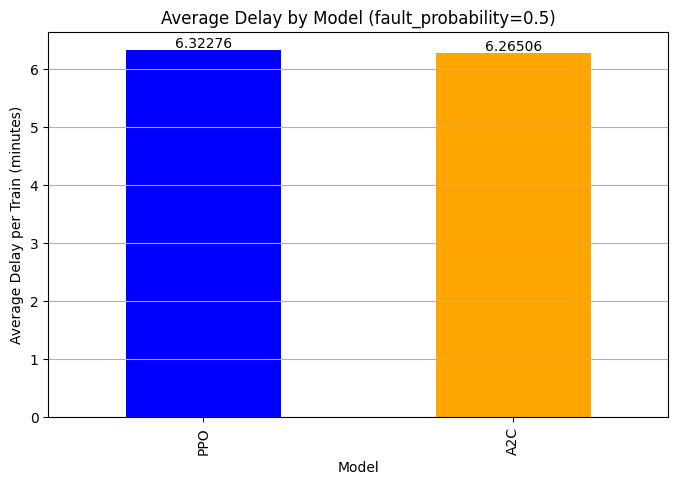

In [36]:
FP = 0.5

mean_ppo,  std_ppo  = evaluate_delay_model(model_ppo, fault_prob=FP)
mean_a2c,  std_a2c  = evaluate_delay_model(model,     fault_prob=FP)

df_models = pd.DataFrame({
    "Model": ["PPO", "A2C"],
    "Mean Avg Delay": [mean_ppo, mean_a2c],
    "Std": [std_ppo, std_a2c]
})
colors=['blue','orange']
ax = df_models.plot(kind="bar", x="Model", y="Mean Avg Delay", legend=False, figsize=(8,5),color=colors)
ax.set_ylabel("Average Delay per Train (minutes)")
ax.set_title(f"Average Delay by Model (fault_probability={FP})")
ax.grid(axis="y")
ax.bar_label(ax.containers[0])
plt.show()

In [37]:
def collect_episode_avg_delay(model, fault_prob=0.3, num_episodes=100, max_steps=200):
    vals = []
    for _ in range(num_episodes):
        env = RailwayRescheduleEnv(schedule, fault_probability=fault_prob)
        env.add_random_delays = True
        obs, _ = env.reset()
        for _ in range(max_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, term, trunc, _ = env.step(action)
            if term or trunc:
                break
        d = np.array(list(env.delay.values()), dtype=float)
        vals.append(float(np.mean(np.clip(d, 0, None))) if d.size else np.nan)
    return vals

In [38]:
FAULT_PROB = 0.30
N_EPISODES = 100
MAX_STEPS = 200
WINDOW = 10

ppo_delays = collect_episode_avg_delay(model_ppo, fault_prob=FAULT_PROB,
                                       num_episodes=N_EPISODES, max_steps=MAX_STEPS)
a2c_delays = collect_episode_avg_delay(model,     fault_prob=FAULT_PROB,
                                       num_episodes=N_EPISODES, max_steps=MAX_STEPS)

In [39]:
ppo_s = pd.Series(ppo_delays).rolling(window=WINDOW, min_periods=1).mean()
a2c_s = pd.Series(a2c_delays).rolling(window=WINDOW, min_periods=1).mean()

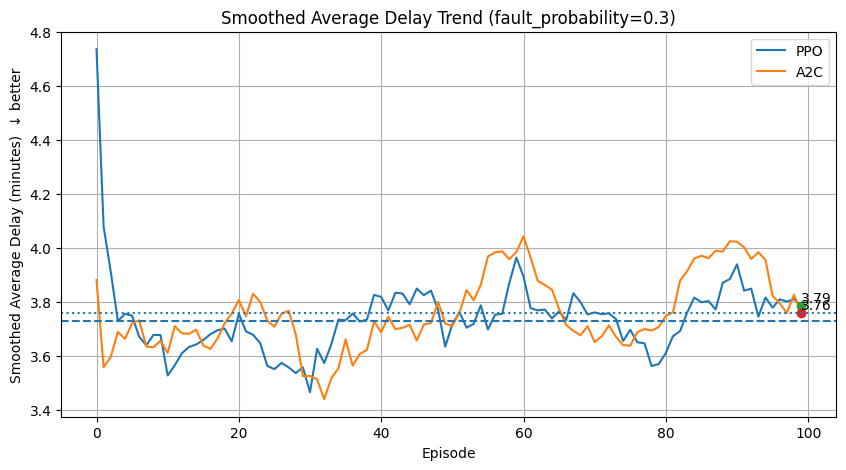

In [40]:
ax = pd.DataFrame({"PPO": ppo_s, "A2C": a2c_s}).plot(figsize=(10,5))
x_last = len(ppo_s) - 1
ax.plot(x_last, ppo_s.iloc[-1], marker="o")
ax.plot(x_last, a2c_s.iloc[-1], marker="o")
ax.text(x_last, ppo_s.iloc[-1], f"{ppo_s.iloc[-1]:.2f}", ha="left", va="bottom")
ax.text(x_last, a2c_s.iloc[-1], f"{a2c_s.iloc[-1]:.2f}", ha="left", va="bottom")
ax.set_xlabel("Episode")
ax.axhline(np.mean(ppo_delays), linestyle="--")
ax.axhline(np.mean(a2c_delays), linestyle=":")
ax.set_ylabel("Smoothed Average Delay (minutes)  ↓ better")
ax.set_title(f"Smoothed Average Delay Trend (fault_probability={FAULT_PROB})")
ax.grid(True)
plt.show()

In [56]:
import numpy as np
try:
    import gymnasium as gym
except ImportError:
    import gym as gym

def as_env_action(a, space):
    # Discrete
    if isinstance(space, gym.spaces.Discrete):
        x = int(np.asarray(a).ravel()[0])
        return int(x % space.n)  # keep in range

    # MultiDiscrete
    if hasattr(gym.spaces, "MultiDiscrete") and isinstance(space, gym.spaces.MultiDiscrete):
        x = np.asarray(a, dtype=np.int64).ravel()
        return (x % space.nvec).astype(int)

    # Tuple (handle each subspace)
    if isinstance(space, gym.spaces.Tuple):
        a = a if isinstance(a, (list, tuple)) else np.asarray(a, dtype=object).tolist()
        return tuple(as_env_action(ai, sp) for ai, sp in zip(a, space.spaces))

    # Box
    if isinstance(space, gym.spaces.Box):
        x = np.asarray(a, dtype=space.dtype)
        return np.clip(x, space.low, space.high)

    # Fallback
    return a

In [60]:
#Reward
# Stochastic eval wrapper (minimal + safe)
def collect_episode_rewards_STOCH(model, fault_prob=0.3, num_episodes=100, max_steps=12000, eps=0.0):
    rewards = []
    for _ in range(num_episodes):
        env = RailwayRescheduleEnv(schedule, fault_probability=fault_prob)
        env.add_random_delays = True
        obs, _ = env.reset(seed=None)

        ep_reward = 0.0
        t = 0
        while True:
            # tiny epsilon-greedy
            if eps > 0.0 and np.random.rand() < eps:
                a = env.action_space.sample()
            else:
                a, _ = model.predict(obs, deterministic=False)

            a = as_env_action(a, env.action_space)
            obs, r, term, trunc, _ = env.step(a)
            ep_reward += float(r)
            t += 1
            if term or trunc or t >= max_steps:
                break
        rewards.append(ep_reward)
    return rewards

In [58]:
def peek_one_episode(model):
    env = RailwayRescheduleEnv(schedule, fault_probability=0.3)
    env.add_random_delays = True
    obs, _ = env.reset(seed=None)

    a, _ = model.predict(obs, deterministic=False)
    a = as_env_action(a, env.action_space)
    _, r, _, _, _ = env.step(a)
    print("First-step reward (model, stochastic):", float(r))

peek_one_episode(model_ppo)

First-step reward (model, stochastic): -48.0


In [42]:
#Random Reward
def collect_random_rewards(fault_prob=0.3, num_episodes=100, max_steps=200):
    rewards = []
    for _ in range(num_episodes):
        env = RailwayRescheduleEnv(schedule, fault_probability=fault_prob)
        env.add_random_delays = True
        obs, _ = env.reset()
        ep_reward = 0.0
        for _ in range(max_steps):
            action = env.action_space.sample()
            obs, r, term, trunc, _ = env.step(action)
            ep_reward += float(np.asarray(r).item())
            if term or trunc:
                break
        rewards.append(ep_reward)
    return rewards

In [43]:
def as_env_action(a, action_space):
    if isinstance(action_space, gym.spaces.Discrete) or hasattr(action_space, "n"):
        if isinstance(a, (list, tuple, np.ndarray)):
            a = np.asarray(a).item()
        return int(a)
    return a

In [61]:
FAULT_PROB = 0.30
N_EPISODES = 100
MAX_STEPS = 12000

ppo_rewards = collect_episode_rewards_STOCH(model_ppo, fault_prob=FAULT_PROB,num_episodes=N_EPISODES, max_steps=MAX_STEPS)
a2c_rewards = collect_episode_rewards_STOCH(model,     fault_prob=FAULT_PROB,num_episodes=N_EPISODES, max_steps=MAX_STEPS)


print("PPO mean/std:", np.mean(ppo_rewards), np.std(ppo_rewards))
print("A2C mean/std:", np.mean(a2c_rewards), np.std(a2c_rewards))

PPO mean/std: -87634.49 1409.729920906838
A2C mean/std: -913427.4 1244.4321435899992


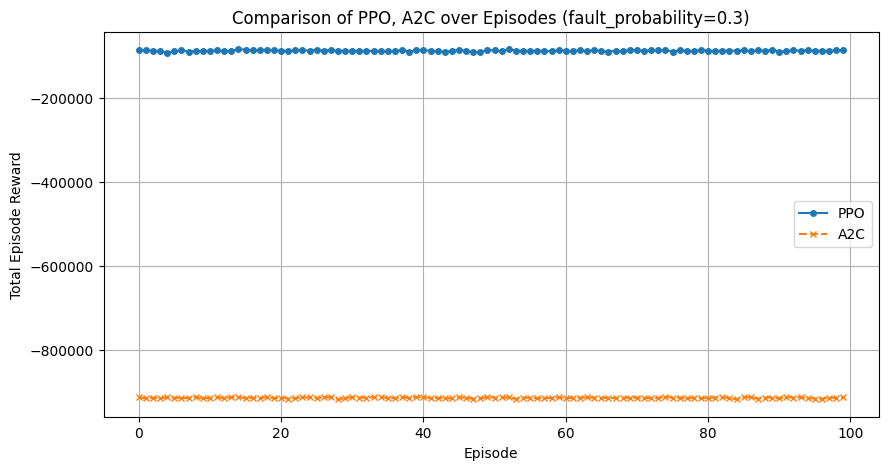

In [62]:
df_plot = pd.DataFrame({
    "PPO": ppo_rewards,
    "A2C": a2c_rewards,
})

ax = df_plot.plot(figsize=(10,5), style=["o-","x--"], markersize=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Total Episode Reward")
ax.set_title(f"Comparison of PPO, A2C over Episodes (fault_probability={FAULT_PROB})")
ax.grid(True)
plt.show()

In [63]:
FAULT_PROBS = [0.00, 0.05, 0.10, 0.20, 0.30, 0.50]
N_EPISODES, MAX_STEPS = 100, 200

rows = []
for fp in FAULT_PROBS:
    # delays
    d_ppo_mean, d_ppo_std = evaluate_delay_model(model_ppo, fp, N_EPISODES, MAX_STEPS)
    d_a2c_mean, d_a2c_std = evaluate_delay_model(model,     fp, N_EPISODES, MAX_STEPS)


    # rewards
    ppo_rewards = collect_episode_rewards_STOCH(model_ppo, fp, N_EPISODES, MAX_STEPS)
    a2c_rewards = collect_episode_rewards_STOCH(model,     fp, N_EPISODES, MAX_STEPS)


    rows += [
        {"Model":"PPO",    "Fault Probability":fp, "Mean Reward":float(np.mean(ppo_rewards)), "Std Reward":float(np.std(ppo_rewards)),
         "Mean Avg Delay":d_ppo_mean, "Std Avg Delay":d_ppo_std},
        {"Model":"A2C",    "Fault Probability":fp, "Mean Reward":float(np.mean(a2c_rewards)), "Std Reward":float(np.std(a2c_rewards)),
         "Mean Avg Delay":d_a2c_mean, "Std Avg Delay":d_a2c_std},

    ]

df_results = pd.DataFrame(rows)

In [65]:
pivot_delay = (df_results.pivot(index="Fault Probability", columns="Model", values="Mean Avg Delay") .sort_index())

In [66]:
pivot_delay

Model,A2C,PPO
Fault Probability,,
0.00,0.000000,0.000000
0.05,0.646008,0.628189
0.10,1.221728,1.239383
0.20,2.475432,2.492922
0.30,3.694897,3.798230
0.50,6.312840,6.243374


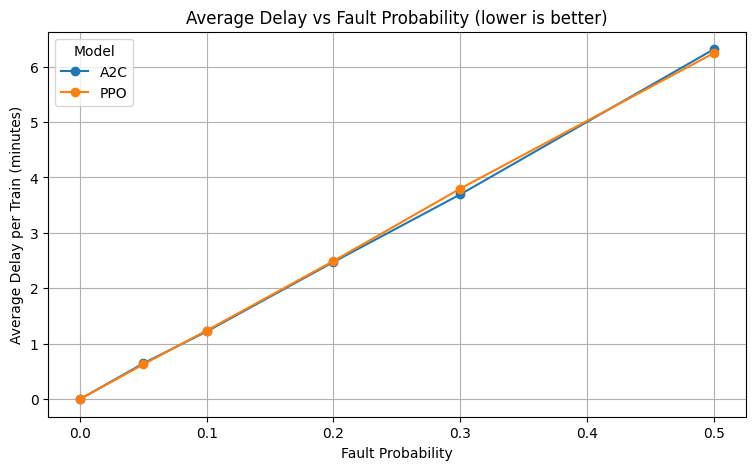

In [67]:
ax = pivot_delay.plot(marker="o", figsize=(9,5))
ax.set_xlabel("Fault Probability")
ax.set_ylabel("Average Delay per Train (minutes)")
ax.set_title("Average Delay vs Fault Probability (lower is better)")
ax.grid(True)
plt.show()

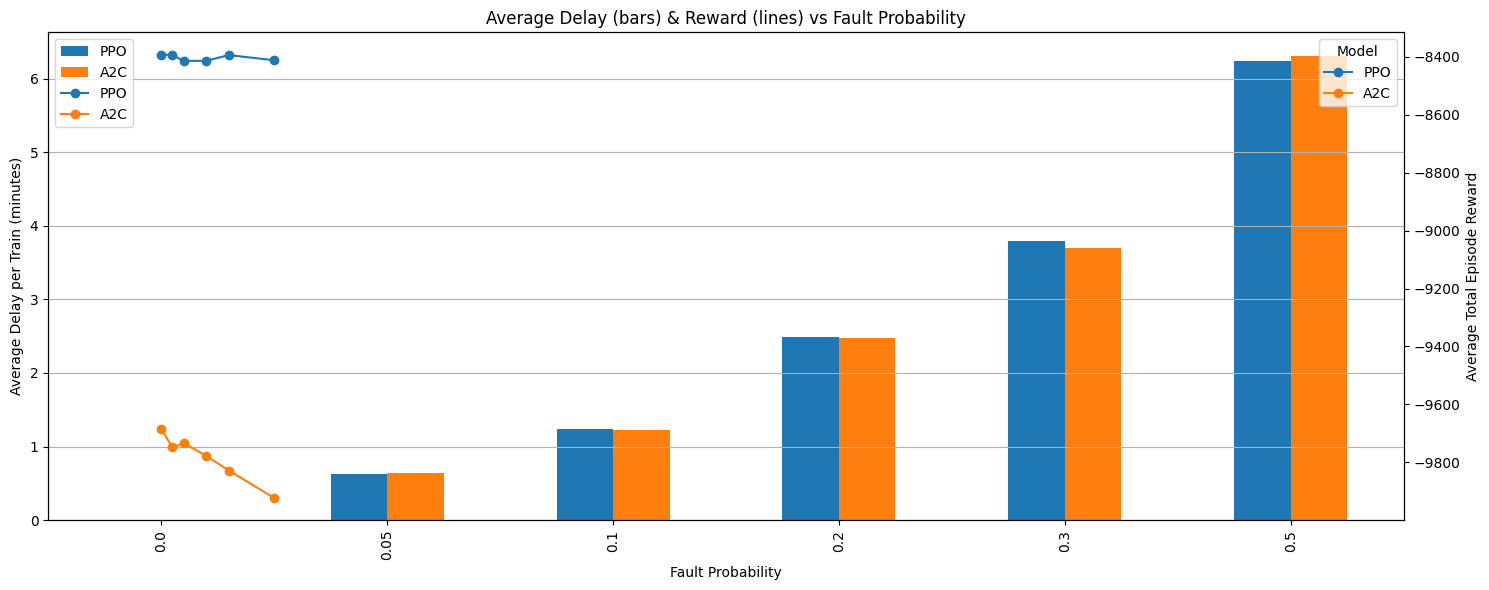

In [64]:
df_results["Model"] = ( df_results["Model"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
    .str.upper())

# pivoting
pivot_delay = (df_results
               .pivot(index="Fault Probability", columns="Model", values="Mean Avg Delay")
               .sort_index())
pivot_reward = (df_results
                .pivot(index="Fault Probability", columns="Model", values="Mean Reward")
                .reindex(pivot_delay.index))

cols = [c for c in ["PPO", "A2C"] if c in pivot_delay.columns]
pivot_delay = pivot_delay[cols]
pivot_reward = pivot_reward[cols]

# plottig delays as bars, rewards as lines
fig, ax1 = plt.subplots(figsize=(15, 6))
pivot_delay.plot(kind="bar", ax=ax1)
ax1.set_xlabel("Fault Probability")
ax1.set_ylabel("Average Delay per Train (minutes)")
ax1.set_title("Average Delay (bars) & Reward (lines) vs Fault Probability")
ax1.grid(axis="y")

ax2 = ax1.twinx()
pivot_reward.plot(ax=ax2, marker="o")
ax2.set_ylabel("Average Total Episode Reward")

# merging legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()
plt.show()